In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
# Load data
company = 'AAPL'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,6,1)
prediction_days = 90

data = pdr.DataReader(company, 'yahoo', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-26,81.059998,79.125000,80.875000,79.182503,125522000.0,78.786133
2020-05-27,79.677498,78.272499,79.035004,79.527496,112945200.0,79.129402
2020-05-28,80.860001,78.907501,79.192497,79.562500,133560800.0,79.164230
2020-05-29,80.287498,79.117500,79.812500,79.485001,153598000.0,79.087120
2020-06-01,80.587502,79.302498,79.437500,80.462502,80791200.0,80.059723


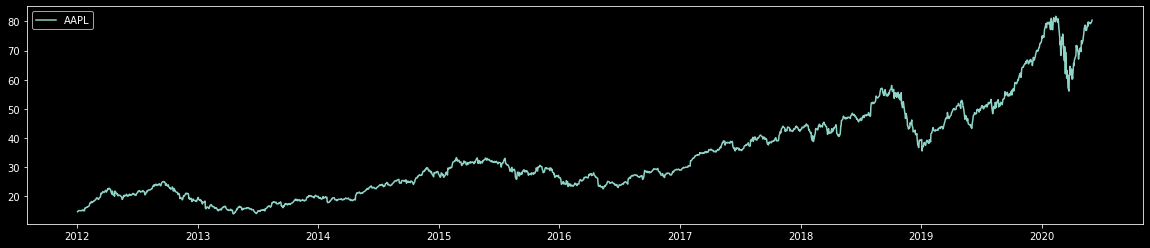

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(data['Close'], label=f'{company}')
plt.legend()
plt.show()

In [ ]:
# Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [ ]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next price closing

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=25, batch_size=32, shuffle=False)

# model.save
# model.load

Epoch 1/25
64/64 [==============================] - 12s 115ms/step - loss: 0.0048
Epoch 2/25
64/64 [==============================] - 8s 122ms/step - loss: 0.0229
Epoch 3/25
64/64 [==============================] - 8s 121ms/step - loss: 0.0210
Epoch 4/25
64/64 [==============================] - 8s 122ms/step - loss: 0.0209
Epoch 5/25
64/64 [==============================] - 8s 124ms/step - loss: 0.0193
Epoch 6/25
64/64 [==============================] - 8s 122ms/step - loss: 0.0012
Epoch 7/25
64/64 [==============================] - 8s 123ms/step - loss: 6.5890e-04
Epoch 8/25
64/64 [==============================] - 8s 123ms/step - loss: 0.0014
Epoch 9/25
64/64 [==============================] - 8s 123ms/step - loss: 5.8799e-04
Epoch 10/25
64/64 [==============================] - 8s 123ms/step - loss: 5.7520e-04
Epoch 11/25
64/64 [==============================] - 8s 123ms/step - loss: 6.0030e-04
Epoch 12/25
64/64 [==============================] - 8s 123ms/step - loss: 5.0917e-04
Epoc

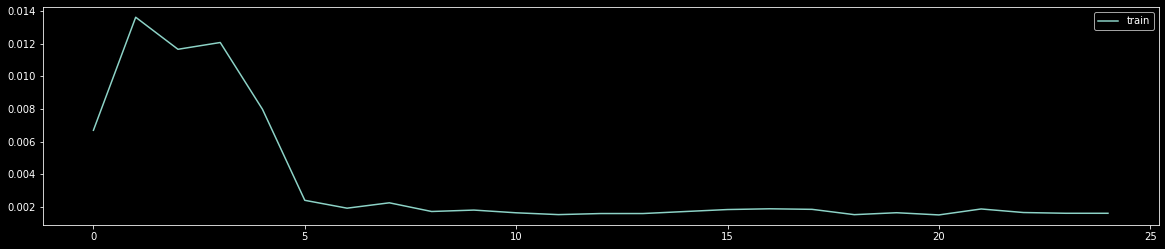

In [ ]:
# plot history
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

Test the model accuracy on existing data

In [ ]:
# Load test data
test_start = end + dt.timedelta(days=1)
test_end = dt.datetime.now()

test_data = pdr.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
# len(your_list) != len(set(your_list)) # check if duplicates

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values # start ASAP
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

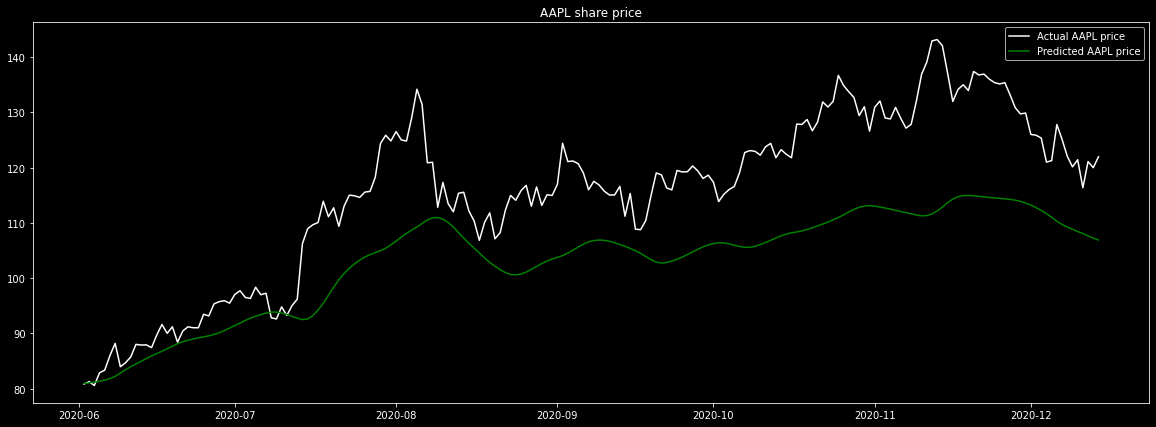

In [ ]:
days = []
for i in range(len(test_data)):
    days.append(test_start + dt.timedelta(days=i))

# Plot the test predictions
plt.rcParams["figure.figsize"] = (20,7)
plt.plot(days, actual_prices, color='white', label=f'Actual {company} price')
plt.plot(days, predicted_prices, color='green', label=f'Predicted {company} price')
plt.title(f'{company} share price')
plt.legend()
plt.show()

In [ ]:
# Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [ ]:
current_day = str(test_data.index[-1]).split()[0]
current_price = round(float(test_data['Close'][-1]), 2)

prediction = model.predict(real_data)
prediction = round(float(scaler.inverse_transform(prediction)), 2)
next_day = str(test_data.index[-1] + dt.timedelta(days=1)).split()[0]

print('\n Current price:')
print(f'{current_day} {company}: {current_price} \n')

print('Next day prediction:')
print(f'{next_day} {company}: {prediction}')


 Current price:
2021-03-11 AAPL: 121.96 

Next day prediction:
2021-03-12 AAPL: 106.68


Prophet

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [ ]:
prophet_df = total_dataset.to_frame()
prophet_df.reset_index(level = 0, inplace = True)
prophet_df.columns = ['ds', 'y']

prophet = Prophet()
prophet.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


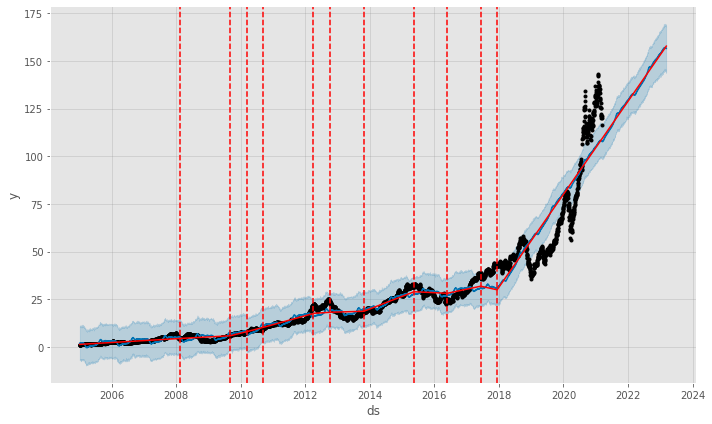

In [ ]:
plt.style.use('ggplot')
future = prophet.make_future_dataframe(periods = 365*2)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

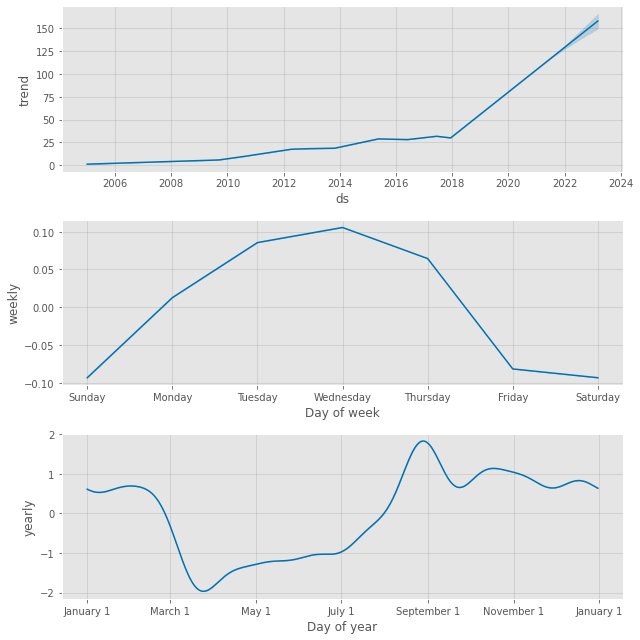

In [ ]:
fig = prophet.plot_components(forecast)

In [ ]:
forecast = forecast.set_index('ds')
forecast.loc[[next_day]]

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2021-03-11,109.149178,99.374802,116.781859,109.149178,109.149178,-1.231856,-1.231856,-1.231856,0.064455,0.064455,0.064455,-1.296311,-1.296311,-1.296311,0.0,0.0,0.0,107.917321


In [ ]:
forecast = forecast[['yhat']]

current_day = str(test_data.index[-1]).split()[0]
current_price = round(float(test_data['Close'][-1]), 2)

prediction = round(float(forecast.loc[[next_day]]['yhat']),2)
next_day = str(test_data.index[-1] + dt.timedelta(days=1)).split()[0]

print('Current price:')
print(f'{current_day} {company}: {current_price} \n')

print('Next day prediction:')
print(f'{next_day} {company}: {prediction}')

Current price:
2021-03-10 AAPL: 119.98 

Next day prediction:
2021-03-11 AAPL: 107.92
